#### End Goal  
Make a model that can predict the prices of house based on inputs of location, size, number of bedrooms, number of bathrooms, etc.

#### **Fetch Data**

In [3]:
import os
import zipfile

dataset_zip_path = os.path.join("datasets", "Delhi.zip")
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall("datasets/Delhi")
    
dataset = os.path.join("datasets", "Delhi", "Delhi_v2.csv")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import Counter, defaultdict, namedtuple
import random

In [5]:
housing = pd.read_csv(dataset)
housing.head(3)

Unnamed: 0       price                            Address    area  \
0           0   5600000.0  Noida Extension, Noida, Delhi NCR  1350.0   
1           1   8800000.0      Sector 79, Gurgaon, Delhi NCR  1490.0   
2           2  16500000.0     Vaishali, Ghaziabad, Delhi NCR  2385.0   

    latitude  longitude  Bedrooms  Bathrooms  Balcony              Status  \
0  28.608850  77.460560       3.0        3.0      NaN  Under Construction   
1  28.374236  76.952416       3.0        3.0      NaN       Ready to Move   
2  28.645769  77.385110       4.0        5.0      NaN       Ready to Move   

       neworold  parking Furnished_status  Lift Landmarks type_of_building  \
0  New Property      NaN              NaN   2.0       NaN             Flat   
1  New Property      NaN   Semi-Furnished   2.0       NaN             Flat   
2  New Property      1.0      Unfurnished   NaN       NaN             Flat   

                                                desc   Price_sqft  
0  \n\n\n                                Welcome ...  4148.148148  
1  \n\n\n                                Mapsko M...  5906.040268  
2  \n\n\n                                This pro...  6918.238994

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7738 entries, 0 to 7737
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7738 non-null   int64  
 1   price             7738 non-null   float64
 2   Address           7738 non-null   object 
 3   area              7738 non-null   float64
 4   latitude          7738 non-null   float64
 5   longitude         7738 non-null   float64
 6   Bedrooms          7738 non-null   float64
 7   Bathrooms         7738 non-null   float64
 8   Balcony           5166 non-null   float64
 9   Status            7164 non-null   object 
 10  neworold          7738 non-null   object 
 11  parking           2612 non-null   float64
 12  Furnished_status  4124 non-null   object 
 13  Lift              1733 non-null   float64
 14  Landmarks         2759 non-null   object 
 15  type_of_building  7738 non-null   object 
 16  desc              7738 non-null   object 


In [7]:
print(housing['desc'][2].strip())
print(housing['price'][2])
addresses = Counter(housing['Address'])
print(len(addresses))
print(sorted(addresses.items(), key=lambda x: x[1])[:10])

This project is spread across 7 acres of lush green land. The modern architecture of the apartments perfectly complements the dream home desire of buyers. With 4-sided ventilation, wooden flooring and a modular kitchen, Cloud 9 Vaishali aims to provide residents a smooth, and a modern cosmopolitan lifestyle.
                            
more
16500000.0
4145
[('Link Road, F Block, Sector 50, Noida, Uttar Pradesh, Sector 1, Greater Noida, Delhi NCR', 1), ('Jaypee Pavilion Court Sector 128, Noida, Sector 128, Noida, Delhi NCR', 1), ('tower 2, 6th floor, Crossings Republik, Ghaziabad, Delhi NCR', 1), ('Nirala Aspire, GH03, Sector 16C, Hundal, Greater Noida, Uttar Pradesh 201306, Noida Extension Block C, Noida, Delhi NCR', 1), ('Suncity Avenue 102, Sector 102, Gurgaon Bang on Dwarka Expressway having all Facilities of a gated Society., Sector 102, Gurgaon, Delhi NCR', 1), ('Sector 2, Greater Noida, Sector 2, Greater Noida, Delhi NCR', 1), ('H-024, Gulshan Vivante, Sector-137, Noida, Sector 

In [8]:
Districts = {
    'Greater Noida', 'Noida', 'Gurgaon', 'Faridabad', 'Ghaziabad', 'New Delhi',
}
match_address = lambda arrr: next((dist for dist in Districts if dist in arrr), 'addr')

In [9]:
addresses = Counter([match_address(addr) for addr in housing['Address']])
print(len(addresses))
print(addresses.most_common(10))

5
[('Ghaziabad', 2092), ('Noida', 2061), ('Gurgaon', 1802), ('New Delhi', 1295), ('Faridabad', 488)]


In [10]:
housing['District'] = housing['Address'].apply(match_address)
housing.drop(columns=['Address'], inplace=True)
housing.head(3)

Unnamed: 0       price    area   latitude  longitude  Bedrooms  Bathrooms  \
0           0   5600000.0  1350.0  28.608850  77.460560       3.0        3.0   
1           1   8800000.0  1490.0  28.374236  76.952416       3.0        3.0   
2           2  16500000.0  2385.0  28.645769  77.385110       4.0        5.0   

   Balcony              Status      neworold  parking Furnished_status  Lift  \
0      NaN  Under Construction  New Property      NaN              NaN   2.0   
1      NaN       Ready to Move  New Property      NaN   Semi-Furnished   2.0   
2      NaN       Ready to Move  New Property      1.0      Unfurnished   NaN   

  Landmarks type_of_building  \
0       NaN             Flat   
1       NaN             Flat   
2       NaN             Flat   

                                                desc   Price_sqft   District  
0  \n\n\n                                Welcome ...  4148.148148      Noida  
1  \n\n\n                                Mapsko M...  5906.040268    Gurgaon  
2  \n\n\n                                This pro...  6918.238994  Ghaziabad

In [11]:
housing['parking'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7738 entries, 0 to 7737
Series name: parking
Non-Null Count  Dtype  
--------------  -----  
2612 non-null   float64
dtypes: float64(1)
memory usage: 60.6 KB


In [12]:
columns = ['parking', 'Furnished_status', 'neworold', 'type_of_building', 'Bathrooms', 'Balcony', 'Bedrooms', 'Status', 'Lift']
for col in columns:
    print(f'{housing[col].value_counts(dropna=False)}\n')

parking
NaN      5126
1.0      1715
2.0       640
3.0       110
4.0        45
         ... 
20.0        1
145.0       1
99.0        1
303.0       1
179.0       1
Name: count, Length: 66, dtype: int64

Furnished_status
NaN               3614
Semi-Furnished    2199
Unfurnished       1230
Furnished          695
Name: count, dtype: int64

neworold
Resale          6905
New Property     833
Name: count, dtype: int64

type_of_building
Flat                6226
Individual House    1512
Name: count, dtype: int64

Bathrooms
2.0     5051
3.0     1907
4.0      551
5.0      138
6.0       44
7.0       21
8.0       12
9.0       10
10.0       4
Name: count, dtype: int64

Balcony
NaN     2572
2.0     1793
3.0     1516
1.0     1082
4.0      613
5.0      130
6.0       21
7.0        4
10.0       3
8.0        3
9.0        1
Name: count, dtype: int64

Bedrooms
2.0     3525
3.0     3373
4.0      642
5.0       98
6.0       46
7.0       17
9.0       16
10.0      11
8.0       10
Name: count, dtype: int64

Status

In [13]:
print(sum(1 for i in housing['parking'] if i>=10))

66


In [14]:
housing.describe()  

Unnamed: 0         price         area     latitude    longitude  \
count  7738.000000  7.738000e+03  7738.000000  7738.000000  7738.000000   
mean   3868.500000  8.320635e+06  1409.506591    28.552092    77.273476   
std    2233.912524  7.223197e+06   718.929581     0.107420     0.180606   
min       0.000000  1.700000e+06   501.000000    28.240023    76.884101   
25%    1934.250000  4.200000e+06   990.000000    28.455539    77.078590   
50%    3868.500000  6.000000e+06  1250.000000    28.574637    77.345320   
75%    5802.750000  9.500000e+06  1650.000000    28.642520    77.421054   
max    7737.000000  8.500000e+07  9500.000000    28.799748    77.688028   

          Bedrooms    Bathrooms      Balcony      parking         Lift  \
count  7738.000000  7738.000000  5166.000000  2612.000000  1733.000000   
mean      2.708193     2.501163     2.426442     7.673047     1.829198   
std       0.877026     0.867050     1.083677    60.417508     1.192607   
min       2.000000     2.000000     1.000000     1.000000     0.000000   
25%       2.000000     2.000000     2.000000     1.000000     1.000000   
50%       3.000000     2.000000     2.000000     1.000000     2.000000   
75%       3.000000     3.000000     3.000000     2.000000     2.000000   
max      10.000000    10.000000    10.000000  1406.000000    10.000000   

         Price_sqft  
count   7738.000000  
mean    5543.660241  
std     2408.659307  
min     2100.000000  
25%     3950.986915  
50%     4972.674332  
75%     6350.638693  
max    44378.698225

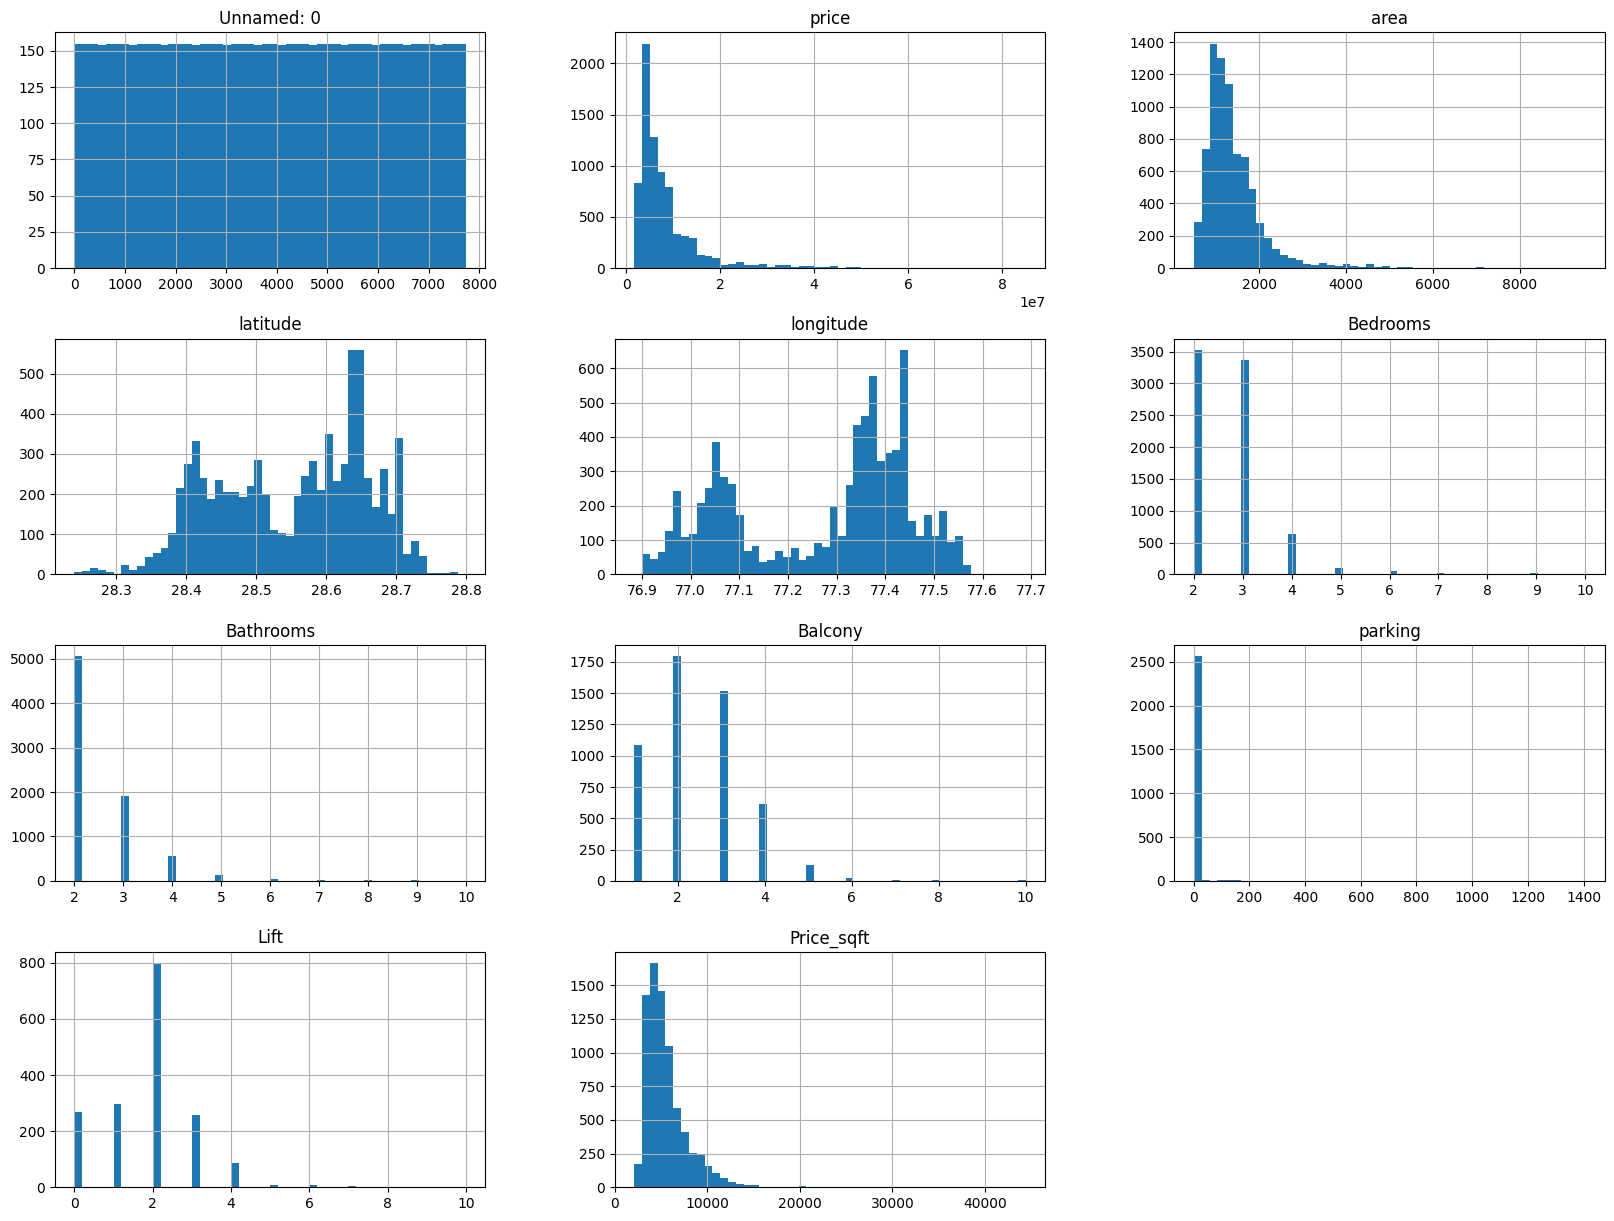

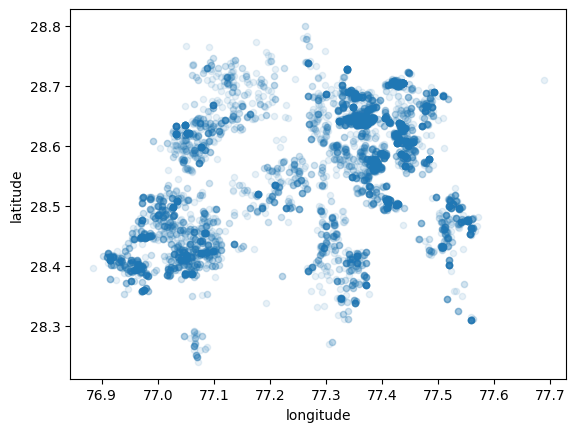

In [15]:
housing.hist(bins=50, figsize=(20,15))
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

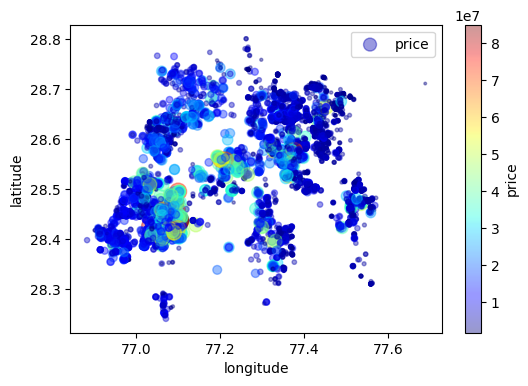

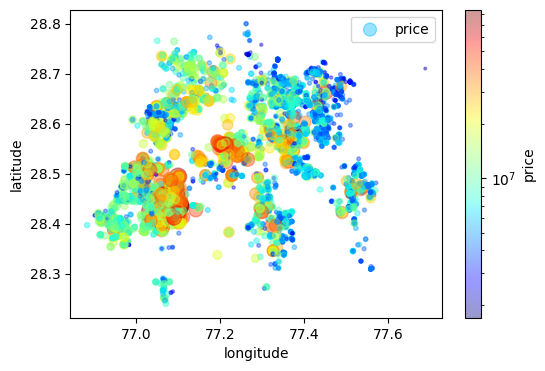

In [22]:
from matplotlib.colors import LogNorm

housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['price']/500000, label='price',
             c='price', cmap=plt.get_cmap('jet'), colorbar=True,
            #  norm = LogNorm(vmin=housing['price'].min(), vmax=housing['price'].max()),
             figsize=(6,4))
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['price']/500000, label='price',
             c='price', cmap=plt.get_cmap('jet'), colorbar=True,
             norm = LogNorm(vmin=housing['price'].min(), vmax=housing['price'].max()),
             figsize=(6,4))

plt.show()

In [17]:
import folium
from folium.plugins import MarkerCluster

m = folium.Map(
    location=[28.6, 77.2],
    zoom_start=11,
    tiles='cartodbpositron'
)

marker_cluster = MarkerCluster().add_to(m)

for _, r in housing.iterrows():
    folium.CircleMarker(
        location=[r.latitude, r.longitude],
        radius=2,
        color=None,
        fill=True,
        fill_opacity=0.4
    ).add_to(marker_cluster)

m

In [18]:
housing.head(4)

Unnamed: 0       price    area   latitude  longitude  Bedrooms  Bathrooms  \
0           0   5600000.0  1350.0  28.608850  77.460560       3.0        3.0   
1           1   8800000.0  1490.0  28.374236  76.952416       3.0        3.0   
2           2  16500000.0  2385.0  28.645769  77.385110       4.0        5.0   
3           3   3810000.0  1050.0  28.566914  77.436434       2.0        2.0   

   Balcony              Status      neworold  parking Furnished_status  Lift  \
0      NaN  Under Construction  New Property      NaN              NaN   2.0   
1      NaN       Ready to Move  New Property      NaN   Semi-Furnished   2.0   
2      NaN       Ready to Move  New Property      1.0      Unfurnished   NaN   
3      3.0                 NaN  New Property      1.0      Unfurnished   2.0   

                    Landmarks type_of_building  \
0                         NaN             Flat   
1                         NaN             Flat   
2                         NaN             Flat   
3  near Gaur Mulberry Mansion             Flat   

                                                desc   Price_sqft   District  
0  \n\n\n                                Welcome ...  4148.148148      Noida  
1  \n\n\n                                Mapsko M...  5906.040268    Gurgaon  
2  \n\n\n                                This pro...  6918.238994  Ghaziabad  
3  \n\n\n                                AIG Roya...  3628.571429      Noida

Parking data is very sparse and ambiguous too.  
So is lift. Hence dropping both of them.

In [19]:
housing.drop(columns=['Unnamed: 0', 'desc', 'Lift', 'parking'], inplace=True)

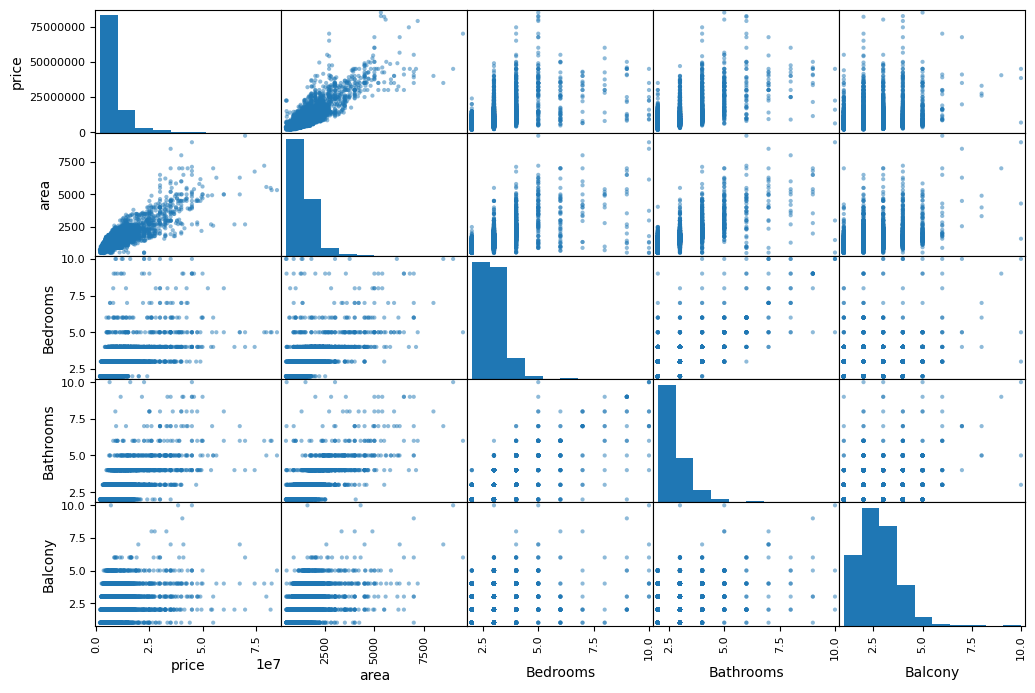

In [20]:
attributes = ['price', 'area', 'Bedrooms', 'Bathrooms', 'Balcony']
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

#### **Observations**  
- Price is highly correlated with area.
- Some coerrelation with number of bedrooms and bathrooms.
- Big effect of locality and even in locality formation of clusters is visible.
- Location effect is hard to see in linear plot but in log scale it is visible.